In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

sns.set(style="whitegrid")


In [66]:
df = pd.read_csv("creditcard.csv")  

print(df.shape)
print(df.head())
print(df['Class'].value_counts())
print(df['Class'].value_counts(normalize=True) * 100)
print(df.isnull().sum().min(), df.isnull().sum().max())


(284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V

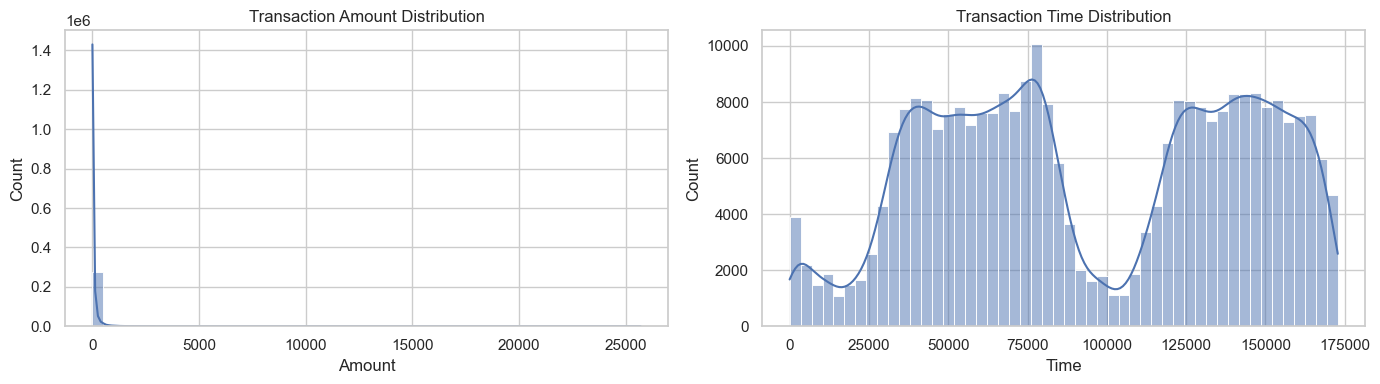

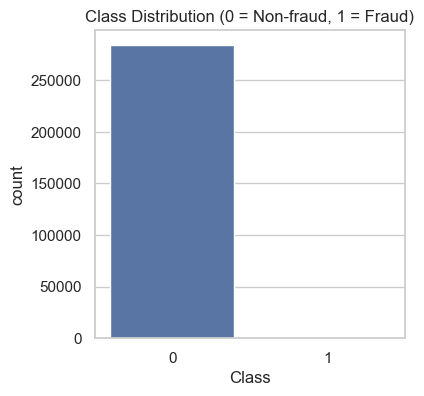

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(df['Amount'], bins=50, kde=True, ax=ax[0])
ax[0].set_title("Transaction Amount Distribution")

sns.histplot(df['Time'], bins=50, kde=True, ax=ax[1])
ax[1].set_title("Transaction Time Distribution")

plt.tight_layout()
plt.show()

plt.figure(figsize=(4,4))
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0 = Non-fraud, 1 = Fraud)")
plt.show()


In [53]:
# downsample majority class BEFORE SMOTE to speed up
df_small_0 = df[df['Class'] == 0].sample(n=30000, random_state=42)
df_small_1 = df[df['Class'] == 1]  # keep all fraud
df_small = pd.concat([df_small_0, df_small_1])

X_small = df_small.drop('Class', axis=1)
y_small = df_small['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small,
    test_size=0.2,
    random_state=42,
    stratify=y_small
)

scaler = StandardScaler()
X_train[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_test[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

rf = RandomForestClassifier(
    n_estimators=100,      # smaller
    max_depth=10,         # limit depth
    n_jobs=-1,
    random_state=42
)

steps_rf = [
    ('o', SMOTE(random_state=42)),
    ('u', RandomUnderSampler(random_state=42)),
    ('model', rf)
]

pipe_rf = ImbPipeline(steps=steps_rf)
pipe_rf.fit(X_train, y_train)

y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:, 1]

print("Confusion matrix (RF):")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification report (RF):")
print(classification_report(y_test, y_pred_rf, digits=4))

print("ROC-AUC (RF):", roc_auc_score(y_test, y_proba_rf))


Confusion matrix (RF):
[[5983   18]
 [  10   88]]

Classification report (RF):
              precision    recall  f1-score   support

           0     0.9983    0.9970    0.9977      6001
           1     0.8302    0.8980    0.8627        98

    accuracy                         0.9954      6099
   macro avg     0.9143    0.9475    0.9302      6099
weighted avg     0.9956    0.9954    0.9955      6099

ROC-AUC (RF): 0.9779815608963132


In [55]:
# Logistic Regression code (with SMOTE + undersampling)
smote = SMOTE(random_state=42)
under = RandomUnderSampler(random_state=42)

steps_lr = [
    ('o', smote),
    ('u', under),
    ('model', LogisticRegression(max_iter=1000, n_jobs=-1))
]

pipe_lr = ImbPipeline(steps=steps_lr)
pipe_lr.fit(X_train, y_train)

y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:, 1]

print("Confusion matrix (LR):")
print(confusion_matrix(y_test, y_pred_lr))

print("\nClassification report (LR):")
print(classification_report(y_test, y_pred_lr, digits=4))

print("ROC-AUC (LR):", roc_auc_score(y_test, y_proba_lr))


Confusion matrix (LR):
[[5836  165]
 [   8   90]]

Classification report (LR):
              precision    recall  f1-score   support

           0     0.9986    0.9725    0.9854      6001
           1     0.3529    0.9184    0.5099        98

    accuracy                         0.9716      6099
   macro avg     0.6758    0.9454    0.7477      6099
weighted avg     0.9883    0.9716    0.9778      6099

ROC-AUC (LR): 0.9616220425847393


In [64]:
#hyperparameter tuning

In [62]:

from sklearn.model_selection import RandomizedSearchCV

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

steps_rf_tune = [
    ('o', SMOTE(random_state=42)),
    ('u', RandomUnderSampler(random_state=42)),
    ('model', rf_base)
]

pipe_rf_tune = ImbPipeline(steps=steps_rf_tune)

param_dist = {
    "model__n_estimators": [50, 100, 150],
    "model__max_depth": [5, 10, None],
    "model__min_samples_split": [2, 5]
}

search = RandomizedSearchCV(
    pipe_rf_tune,
    param_distributions=param_dist,
    n_iter=5,
    scoring="recall",      # focus on catching frauds
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)
print("Best params:", search.best_params_)

best_rf = search.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

print("Confusion matrix (best RF):")
print(confusion_matrix(y_test, y_pred_best))
print("\nClassification report (best RF):")
print(classification_report(y_test, y_pred_best, digits=4))
print("ROC-AUC (best RF):", roc_auc_score(y_test, y_proba_best))


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__max_depth': 5}
Confusion matrix (best RF):
[[5971   30]
 [   9   89]]

Classification report (best RF):
              precision    recall  f1-score   support

           0     0.9985    0.9950    0.9967      6001
           1     0.7479    0.9082    0.8203        98

    accuracy                         0.9936      6099
   macro avg     0.8732    0.9516    0.9085      6099
weighted avg     0.9945    0.9936    0.9939      6099

ROC-AUC (best RF): 0.9801461661151714


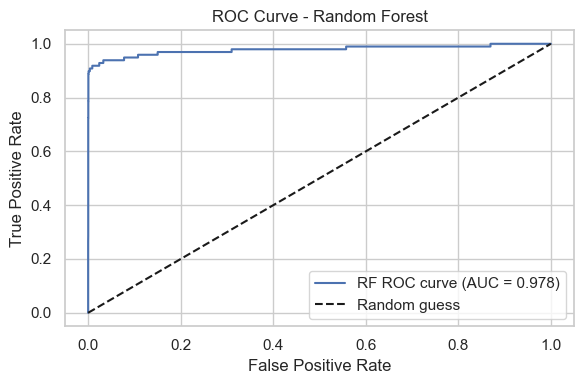

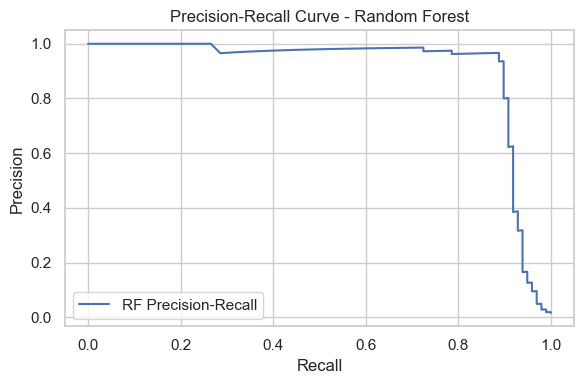

'Shows how Random Forest trades off between false positives and true positives (ROC), \nand between precision and recall for the fraud class (PR curve), which is more informative for imbalanced problems like credit card fraud.'

In [45]:
# --- ROC curve for Random Forest ---

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f"RF ROC curve (AUC = {roc_auc_rf:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

# --- Precision-Recall curve for Random Forest ---

prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)

plt.figure(figsize=(6, 4))
plt.plot(rec_rf, prec_rf, label="RF Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

'''Shows how Random Forest trades off between false positives and true positives (ROC), 
and between precision and recall for the fraud class (PR curve), which is more informative for imbalanced problems like credit card fraud.'''


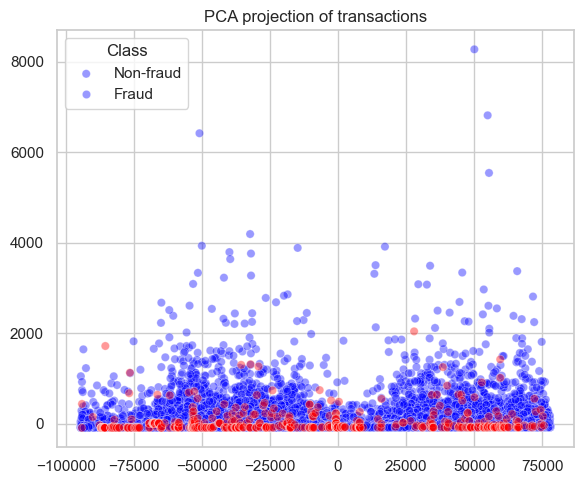

In [41]:
'''This gives you a 2D plot where fraud points (red) typically appear in distinct regions of the PCA space,
illustrating different underlying patterns compared to normal transactions.'''
from sklearn.decomposition import PCA

# Make sure df_small exists; if not, recreate it:
# df_small_0 = df[df['Class'] == 0].sample(n=30000, random_state=42)
# df_small_1 = df[df['Class'] == 1]
# df_small = pd.concat([df_small_0, df_small_1])

X_vis = df_small.drop('Class', axis=1)
y_vis = df_small['Class']

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_vis)

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=y_vis,
    palette={0: "blue", 1: "red"},
    alpha=0.4
)
plt.title("PCA projection of transactions")
plt.legend(title="Class", labels=["Non-fraud", "Fraud"])
plt.tight_layout()
plt.show()
